P1 comme machine

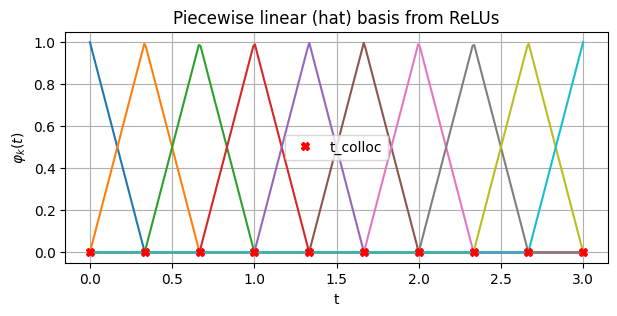

In [56]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np

class S1:
    def __init__(self, t_mesh):
        n = len(t_mesh)+2 
        self.t = jnp.zeros(shape=(n))            
        self.t = self.t.at[1:-1].set(t_mesh)
        self.t = self.t.at[0].set(t_mesh[0] - (t_mesh[1] - t_mesh[0]))
        self.t = self.t.at[-1].set(t_mesh[-1] + (t_mesh[-1] - t_mesh[-2]))
        dtinv = 1.0/(self.t[1:] - self.t[:-1])
        self.W = jnp.ones(n)
        self.b = -self.t       
        self.alpha = dtinv[1:]
        self.gamma = dtinv[:-1]
        self.beta = -self.alpha - self.gamma
    def bases(self, t):
        t = jnp.atleast_1d(t)
        # shape (n, len(t))
        y = jnp.maximum(0.0, self.W[:, None] * t[None, :] + self.b[:, None])
        phi = (
        self.alpha[:, None] * y[2:, :]
        + self.beta[:, None] * y[1:-1, :]
        + self.gamma[:, None] * y[:-2, :]
        )
        return phi
    def forward(self, params, t):
        t = jnp.atleast_1d(t)
        return jnp.dot(params, self.bases(t))

# Points de collocation
t0, t1, n_colloc = 0.0, 3.0, 10
t_colloc = jnp.linspace(t0, t1, n_colloc)
s1 = S1(t_colloc)

t_plot = jnp.linspace(t0, t1, 300)
phi = np.asarray(s1.bases(t_plot))  # (n-2, len(t))

plt.figure(figsize=(7,3))
plt.plot(t_plot, phi.T)
plt.plot(np.asarray(t_colloc), np.zeros_like(np.asarray(t_colloc)), 'Xr', label='t_colloc')
plt.title("Piecewise linear (hat) basis from ReLUs")
plt.xlabel("t")
plt.ylabel(r"$\varphi_k(t)$")
plt.grid(True)
plt.legend()
plt.show()

Epoch       0, Loss: 4.500e-01
Epoch      10, Loss: 3.081e-02
Epoch      20, Loss: 1.991e-03
Epoch      30, Loss: 1.286e-04
Epoch      40, Loss: 8.311e-06
Epoch      50, Loss: 5.370e-07
Epoch      60, Loss: 3.469e-08
Epoch      70, Loss: 2.240e-09
Epoch      80, Loss: 9.655e-10
Epoch      90, Loss: 9.370e-10


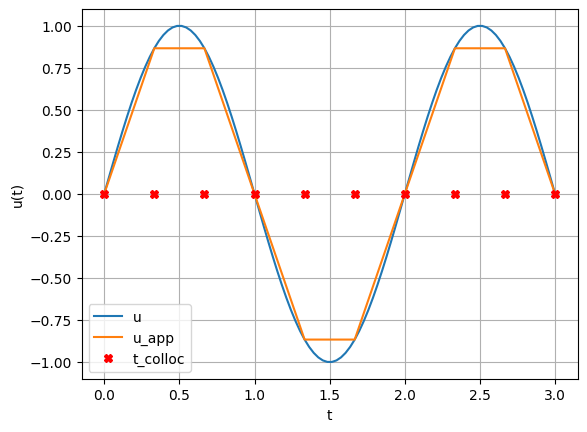

In [57]:
import optax

t0, t1, n_colloc = 0, 3, 10
t_colloc = np.linspace(t0, t1, n_colloc)
s1 = S1(t_colloc)

def u(t):
    return np.sin(np.pi * t)

data = (t_colloc, u(t_colloc))

def loss(params):
    res = data[1] - s1.forward(params,data[0])
    return jnp.mean(res ** 2)
 
params = jnp.zeros(shape=(n_colloc))
optimizer = optax.lbfgs(learning_rate=0.001)
opt_state = optimizer.init(params)
@jax.jit
def train_step(params, opt_state):
    loss_value, grads = jax.value_and_grad(loss)(params)
    updates, opt_state = optimizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value, grads, updates

n_epochs = 100
for epoch in range(n_epochs):
    params, opt_state, loss_value, grads, updates = train_step(params, opt_state)
    if epoch % 10== 0:
        print(f"Epoch {epoch:7d}, Loss: {loss_value:.3e}")

t_plot = np.linspace(t0, t1, 100)
plt.plot(t_plot, u(t_plot), label='u')
plt.plot(t_plot, np.array(s1.forward(params, t_plot)), label='u_app')
plt.plot(t_colloc, np.zeros_like(t_colloc), 'Xr', label='t_colloc')
plt.legend()
plt.xlabel("t")
plt.ylabel("u(t)")
plt.grid(True)
plt.show()
